In [3]:
import argparse
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
# %matplotlib inline
%matplotlib inline

In [4]:
def net_shape(net):
    return jax.tree_map(lambda x: x.shape, net)

In [5]:
from qdax.core.rl_es_parts.es_setup import setup_es

Device count: 1 [GpuDevice(id=0, process_index=0)]


In [28]:
# save_path = "/home/paul/Results/1493061" # no critic
# save_path = "/home/paul/Results/1493081" # bad
# save_path = "/home/paul/Results/1099518" 
save_path = "/home/paul/Results/1107983" 

import jax.numpy as jnp
import json

# Load config
print(save_path + "/config.json")
with open(save_path + "/config.json", "r") as f:
    args = json.load(f)
    # Lists to tuples
    for k, v in args.items():
        if isinstance(v, list):
            args[k] = tuple(v)
    args = argparse.Namespace(**args)
    args.wandb = ""
    print(args)

default = {
    "surrogate_batch": 1024,
    "surrogate": False,
    "deterministic": False,
    # "es": "cmaes"
}
# Replace missing values with default
for k, v in default.items():
    if not hasattr(args, k):
        setattr(args, k, v)

/home/paul/Results/1107983/config.json
Namespace(env_name='halfcheetah_uni', episode_length=1000, evals=100000, seed=3, policy_hidden_layer_sizes=(128, 128), critic_hidden_layer_sizes=(256, 256), deterministic=True, num_init_cvt_samples=50000, num_centroids=1024, min_bd=0.0, max_bd=1.0, es='canonical', pop=100, es_sigma=1.0, sample_mirror=True, sample_rank_norm=True, adam_optimizer=True, learning_rate=1.0, l2_coefficient=0.02, nses_emitter=False, novelty_nearest_neighbors=10, rl=True, testrl=True, carlies=False, elastic_pull=0.0, discount=0.99, actor_injection=True, injection_clip=False, nb_injections=1, critic_training=1000, pg_training=1000, actor_lr=0.001, critic_lr=0.0003, surrogate=False, surrogate_batch=16384, surrogate_omega=0.6, spearman=False, output='/tmpdir/p21049tp/QDax_results/1107983', plot=True, wandb='', tag='elastic_pull', jobid='1107983', log_period=1, debug=False, logall=True, num_gens=1000, algo='Canonical-TestRL-AI', config='Canonical 100 - σ 1.0 | AI 1 | TD3 1000 

In [29]:
args.algo, args.deterministic

('Canonical-TestRL-AI', True)

In [30]:
EM = setup_es(args)

Imported modules
Doing actor injection x 1
layer_shapes [(128,), (18, 128), (128,), (128, 128), (6,), (128, 6)]
sizes [  128  2304   128 16384     6   768]
layer_sizes [128, 2304, 128, 16384, 6, 768]
split_indices [128, 2432, 2560, 18944, 18950]


/home/paul/Dev/QDax/qdax/core/rl_es_parts/es_utils.py:269: UserWarning: This type of repertoire does not store the extra scores computed by the scoring function
  repertoire = ESRepertoire.init(


In [31]:
es = EM.es
env = EM.env
policy_network = EM.policy_network
emitter = EM.emitter
emitter_state = EM.emitter_state
repertoire = EM.repertoire
random_key = EM.random_key
wandb_run  = EM. wandb_run
scoring_fn = EM.scoring_fn

In [32]:
def scores(fitnesses, descriptors) -> jnp.ndarray:
    return fitnesses

In [33]:
emitter.es_emitter._config.actor_injection = False

In [34]:
def make_compute_canonical_update(sigma, sample_number, scoring_fn, es_emitter, injection=False):
    def no_injection(sample_noise, actor, parent):
        # Applying noise
        networks = jax.tree_map(
            lambda x: jnp.repeat(x, sample_number, axis=0),
            parent,
        )
        networks = jax.tree_map(
            lambda mean, noise: mean + sigma * noise,
            networks,
            sample_noise,
        )

        norm = -jnp.inf

        return sample_noise, networks, norm
    if injection:
        # Set the emitter config params 
        es_emitter._config.sample_number = sample_number
        es_emitter._config.sample_sigma = sigma
        injection_fn = es_emitter._inject_actor
    else:
        injection_fn = no_injection 
    flatten_fn = es_emitter.flatten
    
    @jax.jit
    def compute_canonical_update(parent, actor):
        results = {}
        # add 1dim to parent
        parent = jax.tree_map(lambda x: jnp.expand_dims(x, axis=0), parent)

        # print(f"Parent, {net_shape(parent)}")
        mu = sample_number // 2
        # sample points as gaussian noise
        random_key = jax.random.PRNGKey(42)
        random_key, subkey = jax.random.split(random_key)

        sample_noise = jax.tree_map(
            lambda x: jax.random.normal(
                key=subkey,
                shape=jnp.repeat(x, sample_number, axis=0).shape,
            ),
            parent,
        )

        gradient_noise, networks, norm_factor = injection_fn(
                sample_noise,
                actor,
                parent,
            )

        # print(f"networks, {net_shape(networks)}")

        # compute fitness
        random_key, subkey = jax.random.split(random_key)
        fitnesses, _, _, _ = scoring_fn(networks, subkey)
        results["fit_std"] = jnp.std(fitnesses)
        results["fit_min"] = jnp.min(fitnesses)
        results["fit_max"] = jnp.max(fitnesses)
        results["fit_median"] = jnp.median(fitnesses)

        # Parent fitness averaged
        random_key, subkey = jax.random.split(random_key)
        # reproduce the parent network
        multi_parent = jax.tree_map(
            lambda x: jnp.repeat(x, sample_number, axis=0),
            parent,
        )
        parent_fit, _, _, _ = scoring_fn(multi_parent, subkey)
        results["parent_mean"] = jnp.mean(parent_fit)
        results["parent_std"] = jnp.std(parent_fit)
        results["parent_min"] = jnp.min(parent_fit)
        results["parent_max"] = jnp.max(parent_fit)
        results["parent_median"] = jnp.median(parent_fit)

        # compute update
        scores = fitnesses

        ranking_indices = jnp.argsort(scores, axis=0)
        ranks = jnp.argsort(ranking_indices, axis=0)
        ranks = sample_number - ranks # Inverting the ranks

        weights = jnp.where(ranks <= mu, jnp.log(mu+0.5) - jnp.log(ranks), 0)
        weights /= jnp.sum(weights) # Normalizing the weights

        # Reshaping rank to match shape of genotype_noise
        weights = jax.tree_map(
            lambda x: jnp.reshape(
                jnp.repeat(weights.ravel(), x[0].ravel().shape[0], axis=0), x.shape
            ),
            gradient_noise,
        )

        # Computing the update
        # Noise is multiplied by rank
        gradient = jax.tree_map(
            lambda noise, rank: jnp.multiply(noise, rank),
            gradient_noise,
            weights,
        )
        # Noise is summed over the sample dimension and multiplied by sigma
        gradient = jax.tree_map(
            lambda x: jnp.reshape(x, (sample_number, -1)),
            gradient,
        )
        gradient = jax.tree_map(
            lambda g, p: jnp.reshape(
                jnp.sum(g, axis=0) * sigma,
                p.shape,
            ),
            gradient,
            parent,
        )

        # remove one dimension
        gradient = jax.tree_map(lambda x: x.squeeze(0), gradient)

        # flatten
        gradient = flatten_fn(gradient)

        results["gradient"] = gradient
        results["norm_factor"] = norm_factor

        return results
    
    return compute_canonical_update

gen = 600
offspring_genes = jnp.load(f"{save_path}/gen_{gen}_offspring.npy")
offspring = emitter.es_emitter.unflatten(offspring_genes)

actor_genes = jnp.load(f"{save_path}/gen_{gen}_actor.npy")
actor = emitter.es_emitter.unflatten(actor_genes)

compute_canonical_update = make_compute_canonical_update(
    1, 
    10, 
    scoring_fn,
    emitter.es_emitter,
    injection=True,
)

# gradient = compute_canonical_update(offspring, actor)

In [35]:
def project(update_vec, vector):
    update_vec = jnp.dot(update_vec, vector) / jnp.dot(vector, vector)
    # print(f"update_vec, {net_shape(update_vec)}")
    return update_vec

def stability_interpolate(offspring, actor, n_points, sample_size, sigma, EM, injection=False, batch_size=None):
    es_emitter = EM.emitter.es_emitter
    unflatten_fn = jax.vmap(es_emitter.unflatten)
    flatten_fn = es_emitter.flatten
    scoring_fn = EM.scoring_fn

    actor_genes = flatten_fn(actor)
    offspring_genes = flatten_fn(offspring)

    vector = actor_genes - offspring_genes

    # Interpolate from -1 to 2
    alphas = jnp.linspace(-1, 2, n_points)
    interpolated = jnp.outer(alphas, vector) + offspring_genes

    # print first component of each network
    # print("Interpolated", interpolated[:, 0])

    # print(f"networks, {net_shape(networks)}")

    compute_canonical_update = make_compute_canonical_update(
        sigma, sample_size, scoring_fn, es_emitter, injection=injection
    )

    if batch_size is None:
        networks = unflatten_fn(interpolated)

        # vmap compute_canonical_update over networks
        results = jax.vmap(
            lambda network: compute_canonical_update(
                network, actor
            ),
            in_axes=0,
        )(networks)

    else:
        from tqdm import tqdm
        # vmap compute_canonical_update over genomes in batches
        # Split networks into batches
        num_batches = int(jnp.ceil(n_points / batch_size))
        # print(f"num_batches: {num_batches}")
        results = {}
        bar = tqdm(range(num_batches))
        for i in bar:
            genomes = interpolated[i*batch_size:(i+1)*batch_size]
            # print("genomes", genomes.shape)
            networks = unflatten_fn(genomes)
            new_res =jax.vmap(
                    lambda network: compute_canonical_update(
                        network, actor
                    ),
                    in_axes=0,
                )(networks)
            # Append new results to results, create list if empty
            if len(results) == 0:
                results = new_res
            else:
                results = jax.tree_map(
                    lambda x, y: jnp.concatenate([x, y], axis=0),
                    results,
                    new_res,
                )
        # update = jnp.concatenate(results, axis=0)

    # for k, v in results.items():
    #     print(f"{k}: {v.shape}")
    update = results["gradient"]

    # Evaluate the networks to have a baseline
    networks = unflatten_fn(interpolated)
    random_key = jax.random.PRNGKey(42)
    fitnesses, _, _, _ = scoring_fn(networks, random_key)

    # print(f"update, {net_shape(update)}")

    # project onto offspring-actor vector
    update_comp = jax.vmap(project, in_axes=(0, None))(update, vector)

    results["update_comp"] = update_comp
    return alphas, results, fitnesses
    

In [36]:
def pop_spread(offspring, actor, sample_size, sigma, EM, injection=False):
    parent = jax.tree_map(lambda x: jnp.expand_dims(x, axis=0), offspring)
    # print(f"parent, {net_shape(parent)}")
    # print(f"actor, {net_shape(actor)}")

    es_emitter = EM.emitter.es_emitter

    def do_injection(sample_noise, actor, parent):
        x_actor = es_emitter.flatten(actor)
        # print("x_actor shape", x_actor.shape)
        x_parent = es_emitter.flatten(parent)
        # print("x_parent shape", x_parent.shape)
        y_actor = (x_actor - x_parent) / sigma

        norm = jnp.linalg.norm(y_actor)
        # alpha clip es_emitter.c_y / norm to 1
        # norm = jnp.minimum(1, es_emitter.c_y / norm)
        norm = 1
        normed_y_actor = norm * y_actor
        normed_y_net = es_emitter.unflatten(normed_y_actor)
        # Add 1 dimension
        normed_y_net = jax.tree_map(
            lambda x: x[None, ...],
            normed_y_net,
        )

        # Applying noise
        networks = jax.tree_map(
            lambda x: jnp.repeat(x, sample_size, axis=0),
            parent,
        )
        # print("networks shape", jax.tree_map(lambda x: x.shape, networks))
        networks = jax.tree_map(
            lambda mean, noise: mean + sigma * noise,
            networks,
            sample_noise,
        )
        # print("networks shape", jax.tree_map(lambda x: x.shape, networks))

        # Repeat actor
        actor = jax.tree_util.tree_map(
            lambda x: jnp.repeat(x[None, ...], 1, axis=0),
            actor,
        )
        # print("repeated actor shape", jax.tree_map(lambda x: x.shape, actor))

        # Replace the n last one, with n = 1
        networks = jax.tree_util.tree_map(
            lambda x, y: jnp.concatenate([x[:-1], y], axis=0),
            networks,
            actor,
        )

        # replace actor in sample_noise by scaled_actor
        sample_noise = jax.tree_util.tree_map(
            lambda x, y: jnp.concatenate([x[:-1], y], axis=0),
            sample_noise,
            normed_y_net,
        )

        return sample_noise, networks, norm

    def no_injection(sample_noise, actor, parent):
        # Applying noise
        networks = jax.tree_map(
            lambda x: jnp.repeat(x, sample_size, axis=0),
            parent,
        )
        networks = jax.tree_map(
            lambda mean, noise: mean + sigma * noise,
            networks,
            sample_noise,
        )

        norm = -jnp.inf

        return sample_noise, networks, norm
    if injection:
        # Set the emitter config params 
        injection_fn = do_injection
    else:
        injection_fn = no_injection 
    flatten_fn = es_emitter.flatten

    # sample points as gaussian noise
    random_key = jax.random.PRNGKey(42)
    random_key, subkey = jax.random.split(random_key)

    sample_noise = jax.tree_map(
        lambda x: jax.random.normal(
            key=subkey,
            shape=jnp.repeat(x, sample_size, axis=0).shape,
        ),
        parent,
    )

    gradient_noise, networks, norm_factor = injection_fn(
            sample_noise,
            actor,
            parent,
        )
    
    print(f"Norm factor {norm_factor}")

    # print(f"networks, {net_shape(networks)}")

    # compute fitness
    random_key, subkey = jax.random.split(random_key)
    fitnesses, _, _, _ = scoring_fn(networks, subkey)

    # get genomes
    centered = jax.tree_map(
        lambda x, y: x - y,
        networks,
        parent,
    )

    # print(f"centered nets, {net_shape(centered)}")

    centered_genomes = jax.vmap(flatten_fn)(centered)

    # print(f"genomes, {net_shape(centered_genomes)}")

    # project onto parent-actor vector
    vector = flatten_fn(actor) - flatten_fn(parent)
    alphas = jax.vmap(project, in_axes=(0, None))(centered_genomes, vector)

    normed_actor = flatten_fn(actor) - flatten_fn(parent)
    actor_alpha = project(normed_actor, vector)
    print(f"actor_alpha: {actor_alpha}")

    return alphas, fitnesses

In [45]:
def stability_plot(save_path, gen, sigma, injection):
    config = f"gen {gen} | \u03C3={sigma}"
    if injection:
        config += " | Injection"
    if args.deterministic:
        config += " | Deterministic"
    else:
        config += " | Stochastic"
    print(f"Running {config}")

    offspring_genes = jnp.load(f"{save_path}/gen_{gen}_offspring.npy")
    offspring = emitter.es_emitter.unflatten(offspring_genes)

    actor_genes = jnp.load(f"{save_path}/gen_{gen}_actor.npy")
    actor = emitter.es_emitter.unflatten(actor_genes)

    alphas, results, fitnesses = stability_interpolate(offspring, actor, 
                                                n_points=100, 
                                                sample_size=100, 
                                                sigma=sigma, 
                                                EM=EM,
                                                injection=injection,
                                                batch_size=10)
    
    # for k, v in results.items():
    #     print(f"{k}: {v.shape}")
    n_plots = 5
    fig, axs = plt.subplots(n_plots, 1, figsize=(20, 10*n_plots))

    # Update component plot
    update_comp = results["update_comp"]
    idx = 0
    axs[idx].plot(alphas, update_comp)
    axs[idx].scatter(alphas, update_comp, label="Update direction")
    axs[idx].axvline(x=0, color="red")
    axs[idx].axvline(x=1, color="green")
    axs[idx].axhline(y=0, color="black", linestyle="dotted", label="Stability")
    axs[idx].legend()
    axs[idx].set_xlabel("Alpha")
    axs[idx].set_ylabel("Update component")
    title = f"Update component along interpolation \n{config}"
    axs[idx].set_title(title)

    # Fitness plot
    # fitnesses = results["fitnesses"]
    idx = 1
    axs[idx].plot(alphas, fitnesses)
    axs[idx].scatter(alphas, fitnesses, label="Fitness")

    pop_alphas, pop_fitnesses = pop_spread(offspring, actor, sample_size=100, sigma=sigma, EM=EM, injection=injection)
    axs[idx].scatter(pop_alphas, pop_fitnesses, label="Population fitness")
    axs[idx].axvline(x=0, color="red")
    axs[idx].axvline(x=1, color="green")
    axs[idx].legend()
    axs[idx].set_xlabel("Alpha")
    axs[idx].set_ylabel("Fitness")
    title = f"Fitness landscape | Population distribution \n{config}"
    axs[idx].set_title(title)

    # Fitness plot
    idx = 2
    axs[idx].plot(alphas, results["parent_min"], c="red")
    axs[idx].scatter(alphas, results["parent_min"], c="red", label="Parent min fitness")
    axs[idx].plot(alphas, results["parent_median"], c="blue")
    axs[idx].scatter(alphas, results["parent_median"], c="blue", label="Parent median fitness")
    axs[idx].plot(alphas, results["parent_max"], c="green")
    axs[idx].scatter(alphas, results["parent_max"], c="green", label="Parent max fitness")
    axs[idx].axvline(x=0, color="red")
    axs[idx].axvline(x=1, color="green")
    axs[idx].legend()
    axs[idx].set_xlabel("Alpha")
    axs[idx].set_ylabel("Fitness")
    title = f"Parent fitness distribution \n{config}"
    axs[idx].set_title(title)

    # Noise
    idx = 3
    axs[idx].plot(alphas, results["parent_std"], c="red")
    axs[idx].scatter(alphas, results["parent_std"], c="red", label="Parent fitness std")
    axs[idx].axvline(x=0, color="red")
    axs[idx].axvline(x=1, color="green")
    axs[idx].legend()
    axs[idx].set_xlabel("Alpha")
    axs[idx].set_ylabel("Fitness")
    title = f"Fitness noise on center \n{config}"
    axs[idx].set_title(title)


    # Population fitness plot
    idx = 4
    axs[idx].plot(alphas, results["fit_min"], c="red")
    axs[idx].scatter(alphas, results["fit_min"], c="red", label="Pop min fitness")
    axs[idx].plot(alphas, results["fit_median"], c="blue")
    axs[idx].scatter(alphas, results["fit_median"], c="blue", label="Pop median fitness")
    axs[idx].plot(alphas, results["fit_max"], c="green")
    axs[idx].scatter(alphas, results["fit_max"], c="green", label="Pop max fitness")
    axs[idx].axvline(x=0, color="red")
    axs[idx].axvline(x=1, color="green")
    axs[idx].legend()
    axs[idx].set_xlabel("Alpha")
    axs[idx].set_ylabel("Fitness")
    title = f"Population fitness std \n{config}"
    axs[idx].set_title(title)
    config_string = config.replace("| ", "").replace(" ", "_")
    plt.savefig(f"landscapes/gen_{gen}_stability_{config_string}.png")

    plt.show()

Running gen 1000 | σ=1 | Injection | Deterministic


100%|██████████| 10/10 [01:43<00:00, 10.35s/it]


Norm factor 1
actor_alpha: 1.0


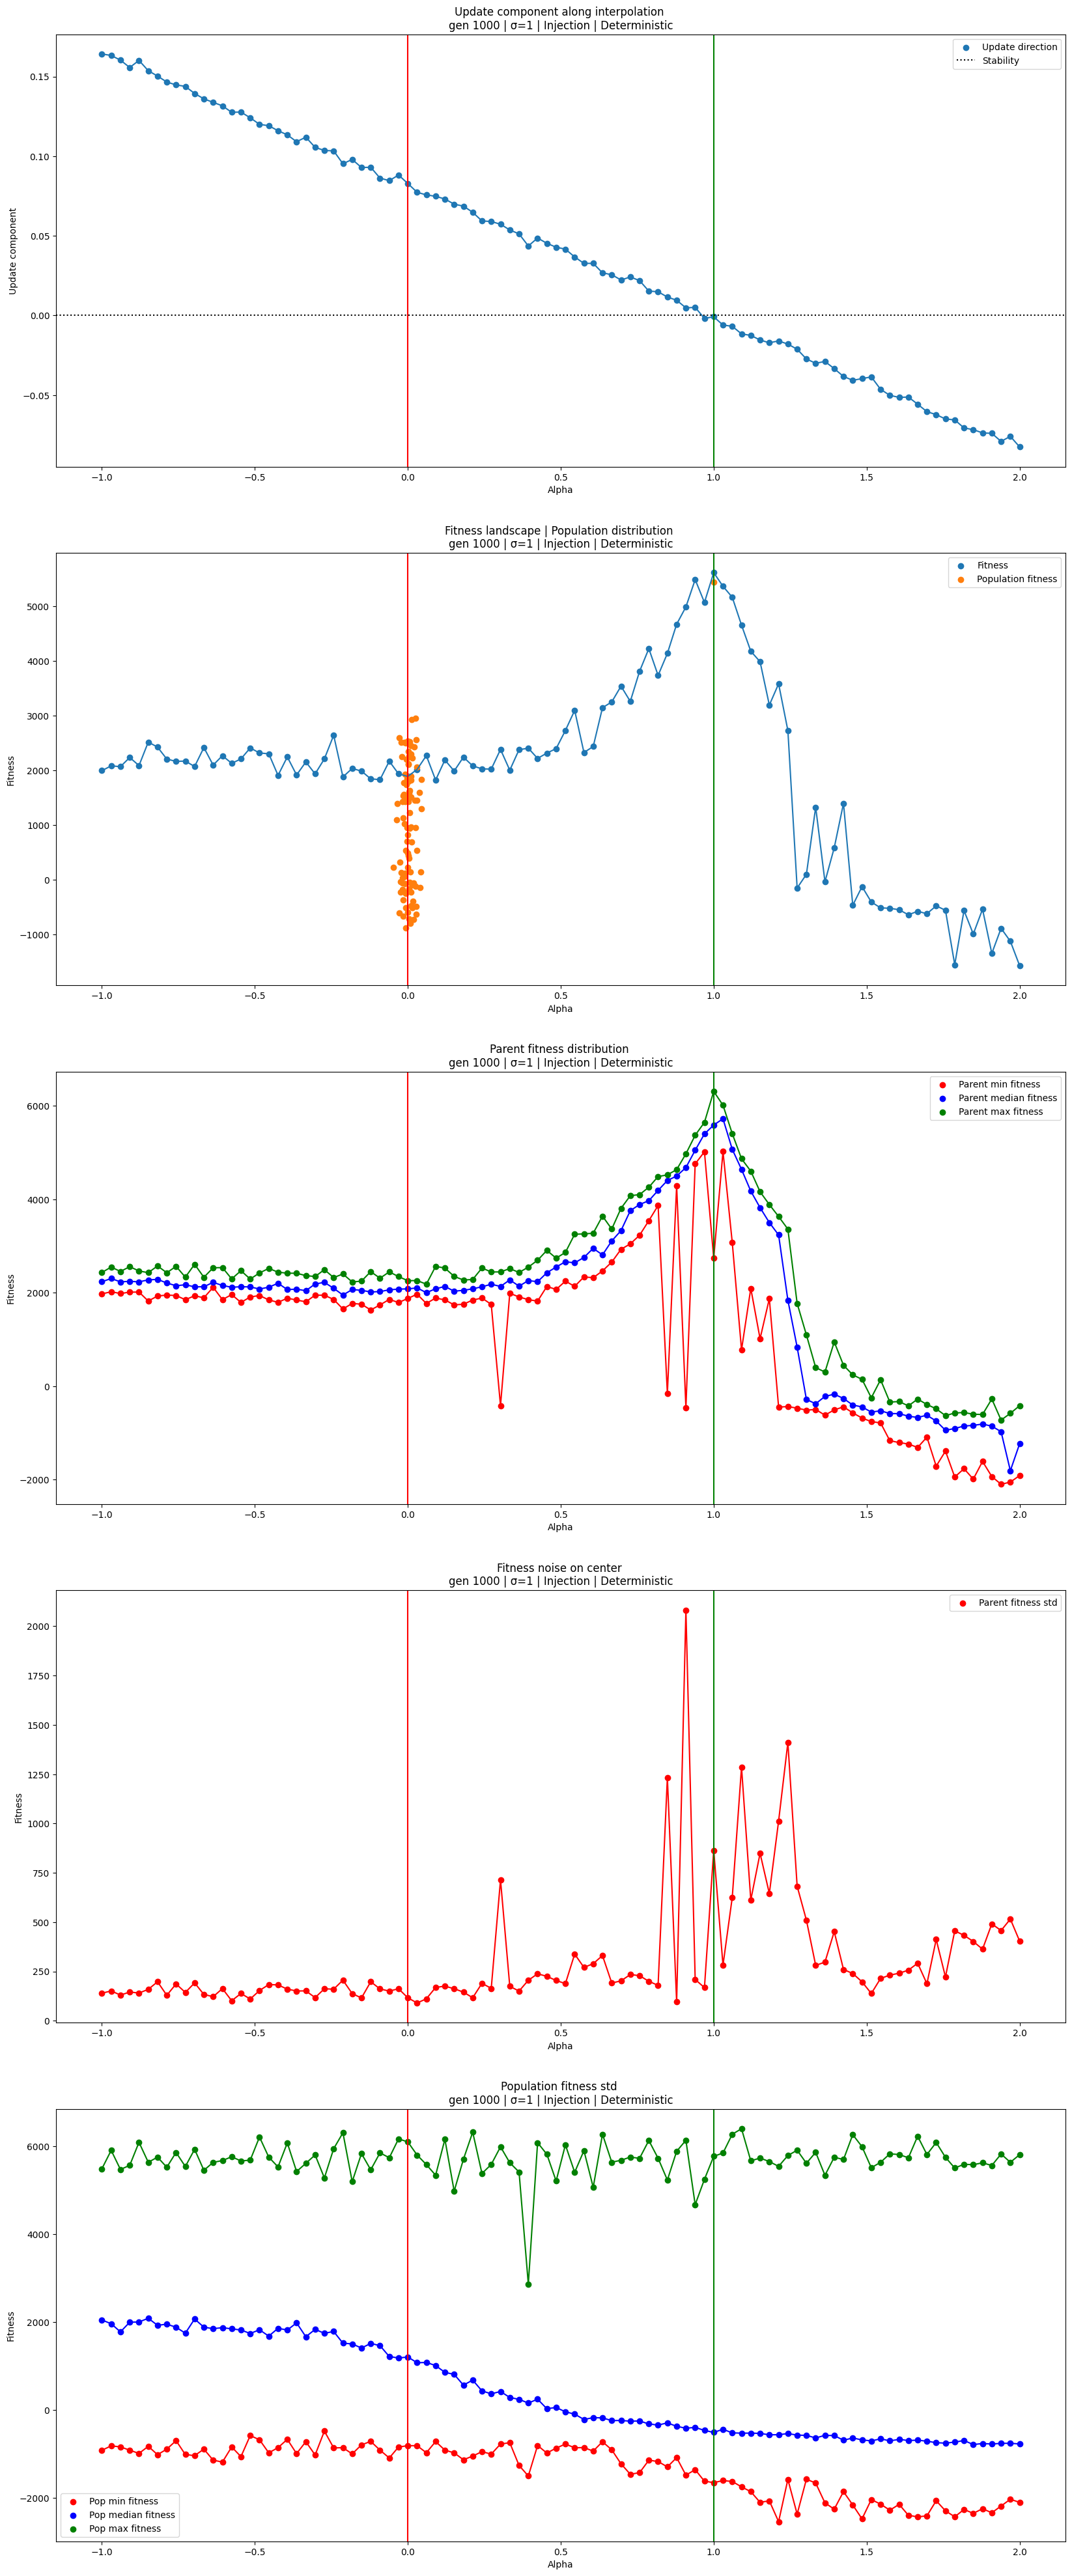

Running gen 1000 | σ=10 | Injection | Deterministic


100%|██████████| 10/10 [01:43<00:00, 10.39s/it]


Norm factor 1
actor_alpha: 1.0


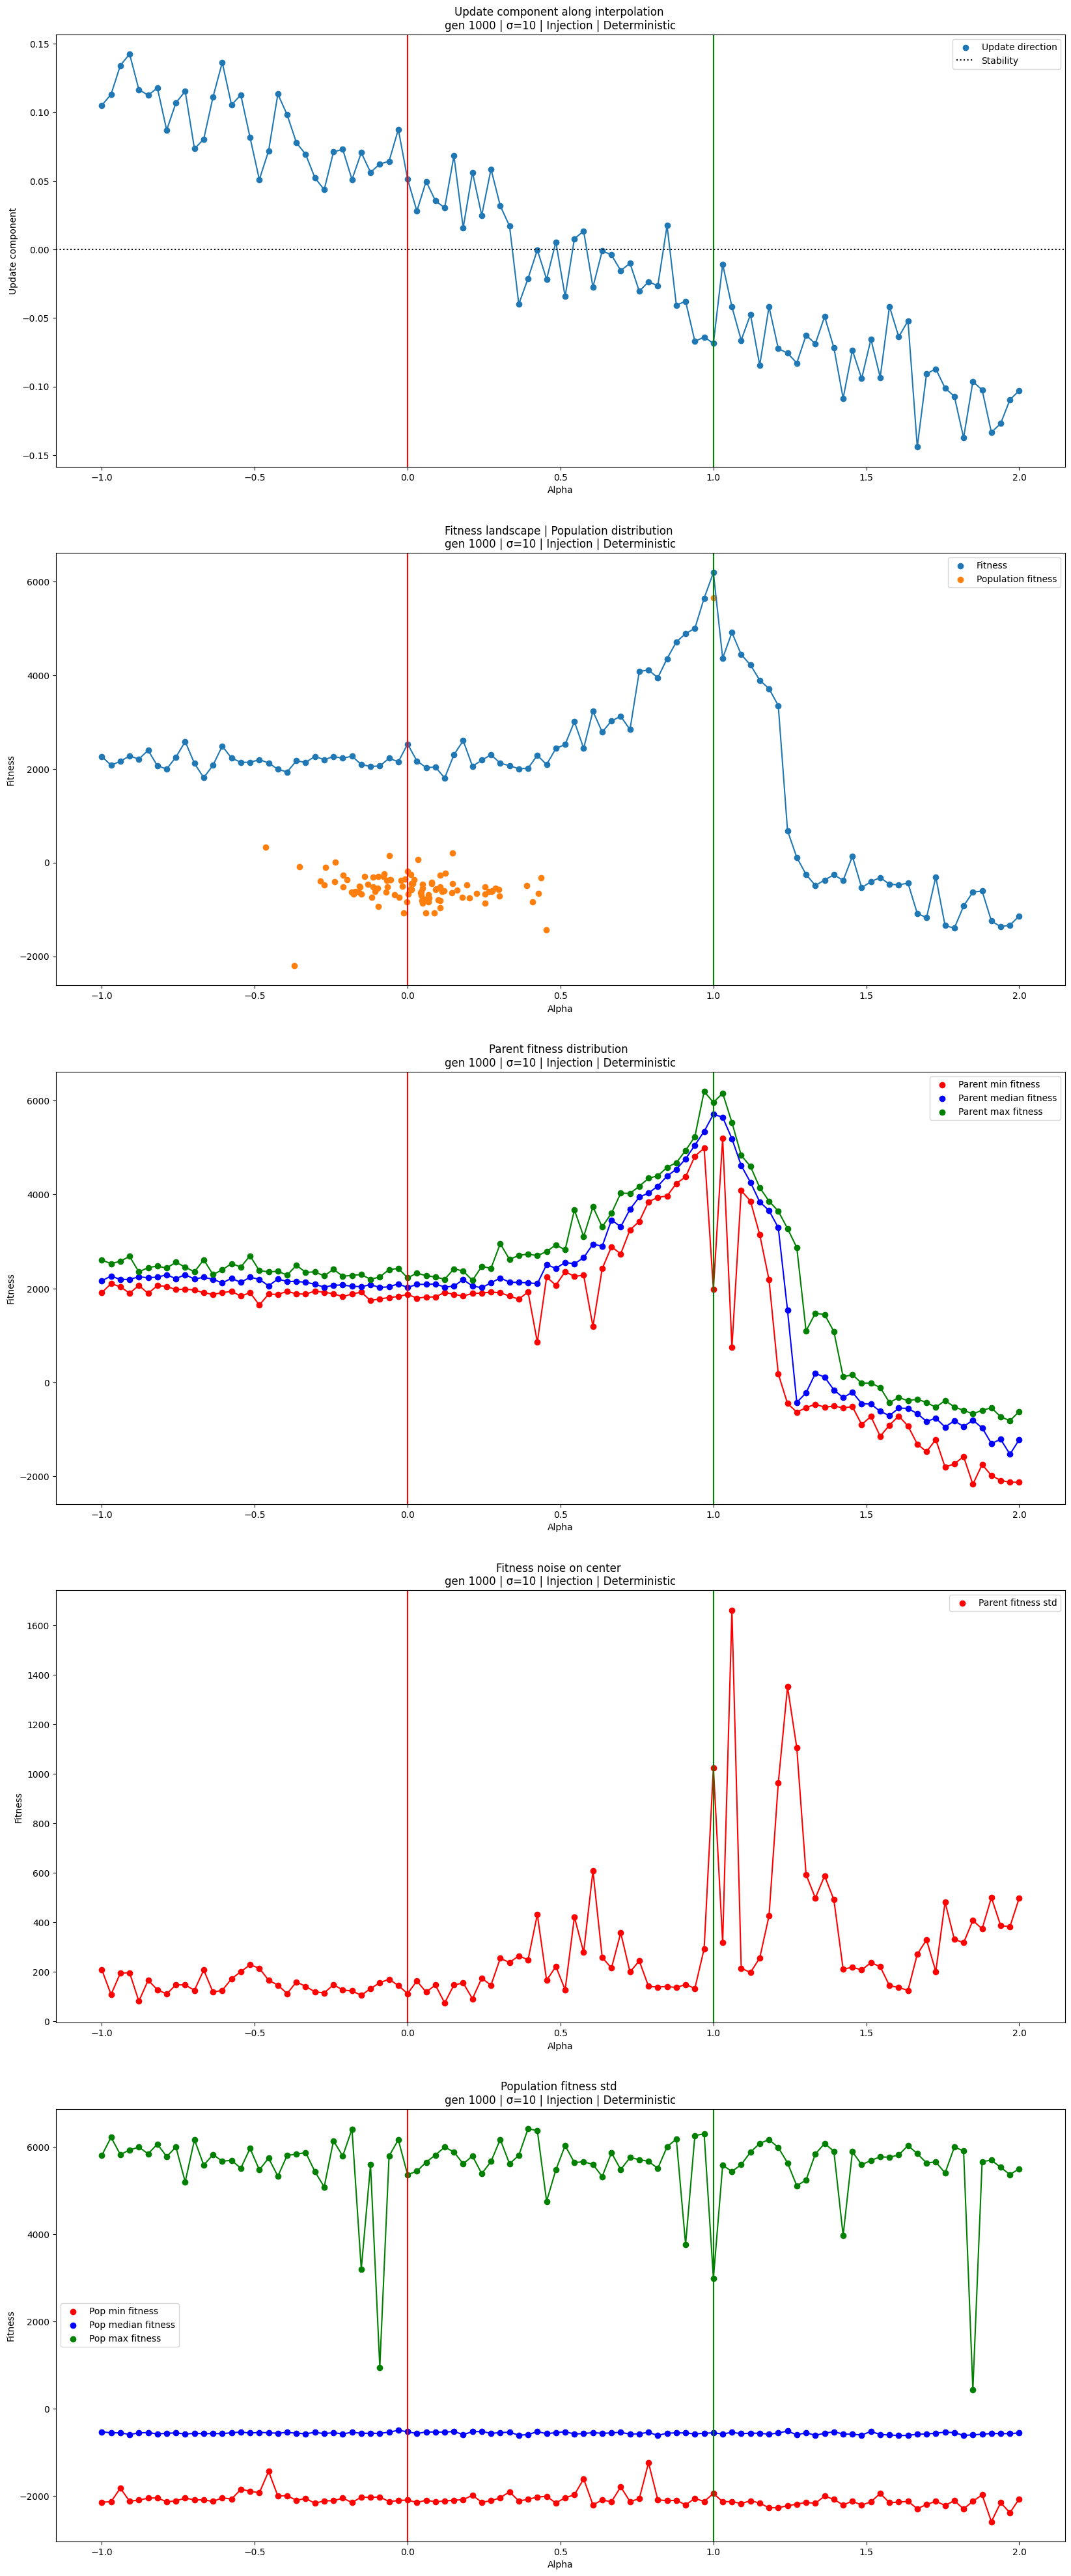

Running gen 1000 | σ=1 | Deterministic


100%|██████████| 10/10 [01:44<00:00, 10.45s/it]


Norm factor -inf
actor_alpha: 1.0


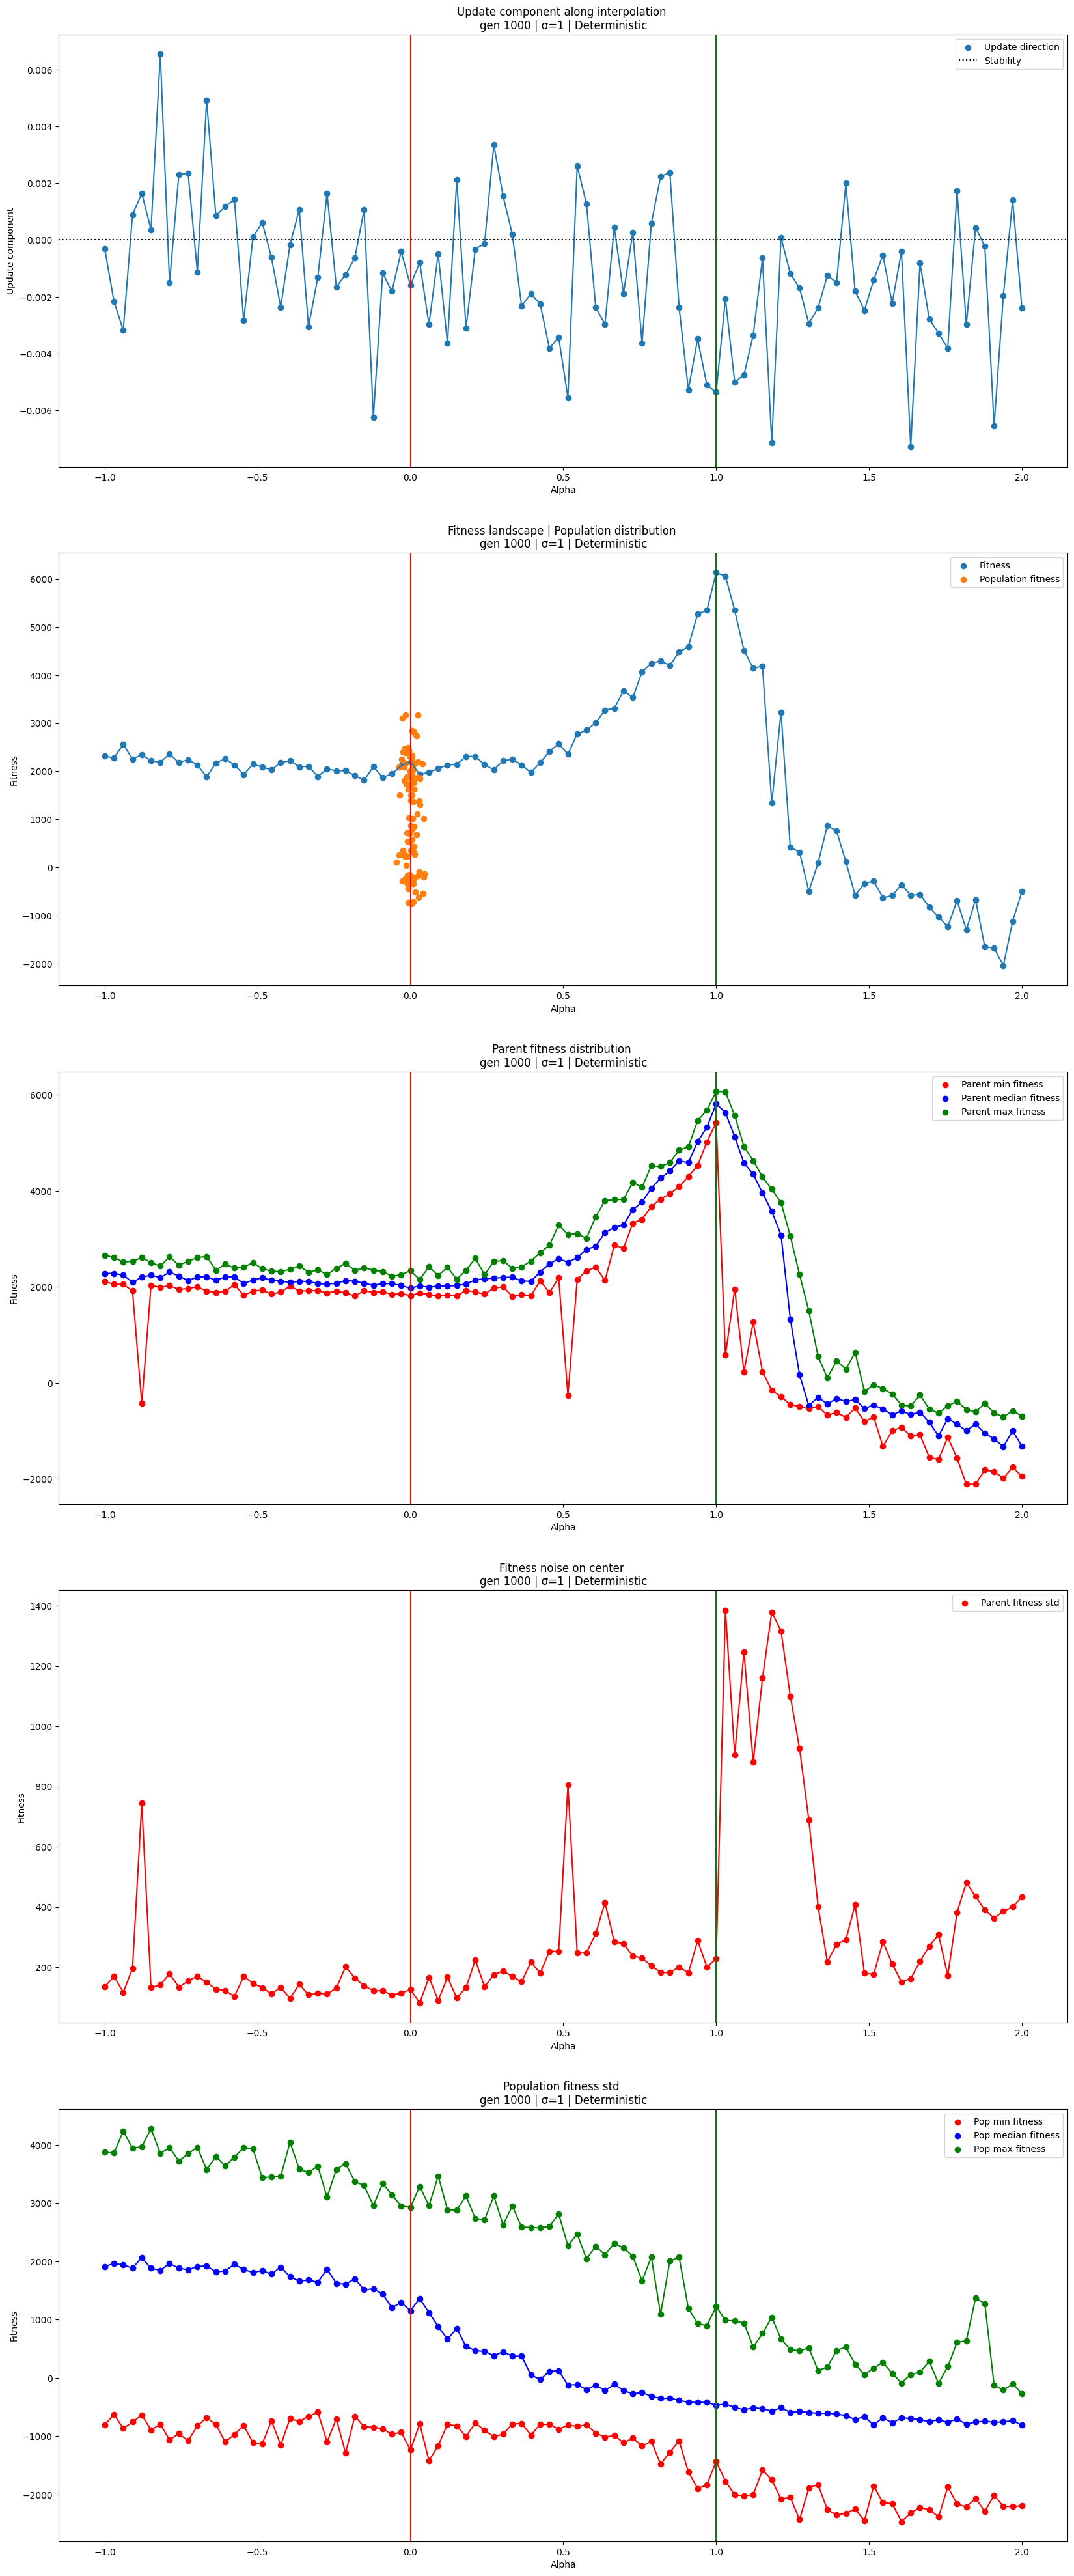

Running gen 1000 | σ=10 | Deterministic


100%|██████████| 10/10 [01:44<00:00, 10.41s/it]


Norm factor -inf
actor_alpha: 1.0


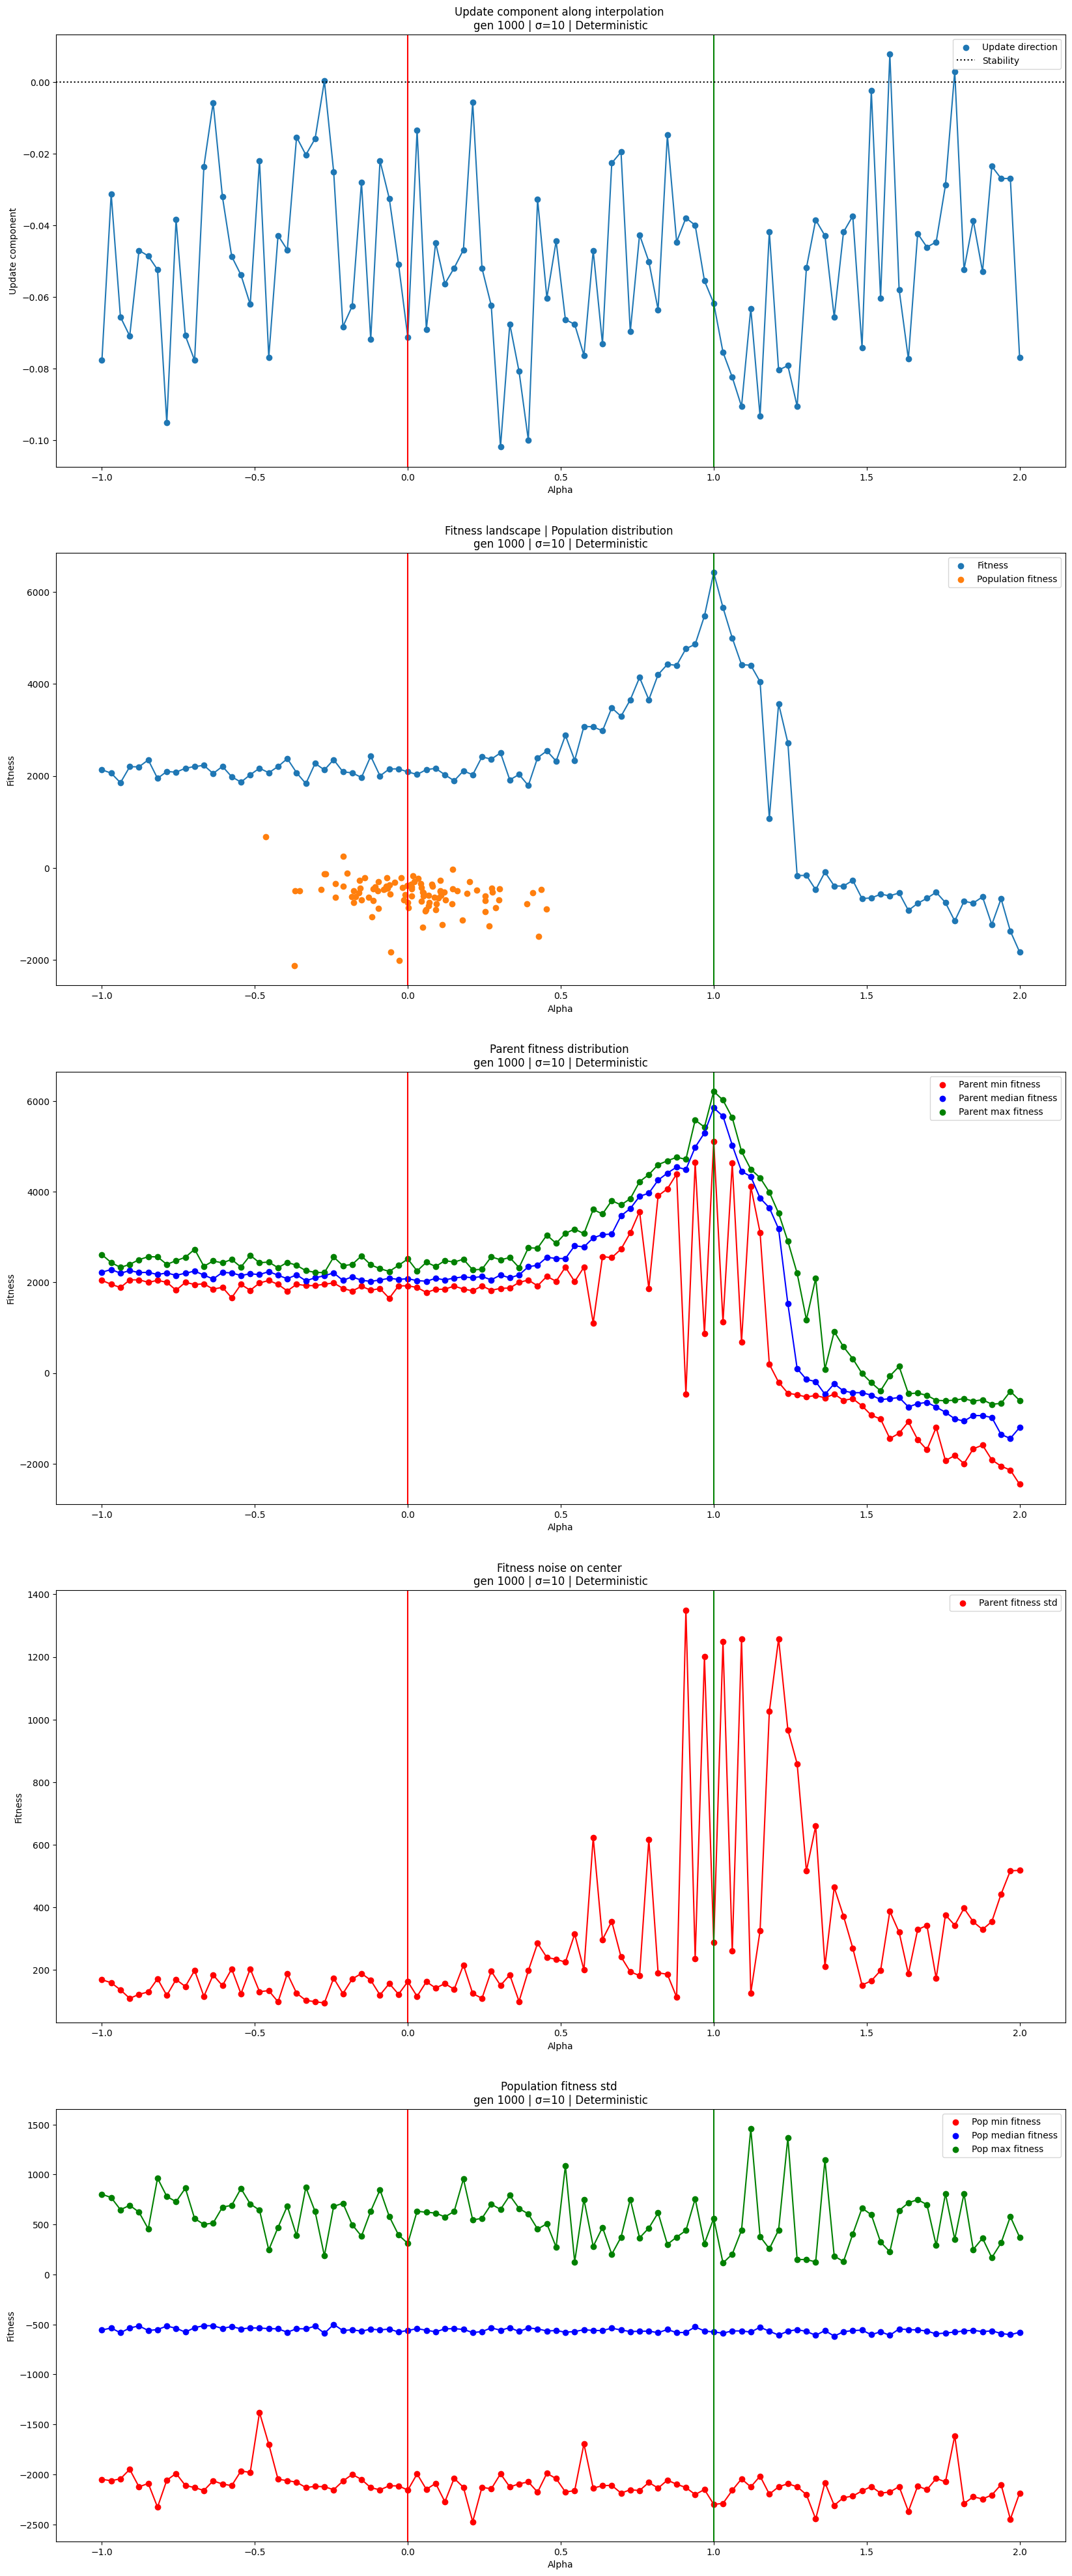

In [47]:
%matplotlib inline

gen = 1000
sigmas = [1, 10]
injection = True

for injection in [True, False]:
    for sigma in sigmas:
        stability_plot(save_path, gen, sigma, injection)

Running gen 1000 | σ=10 | Deterministic


100%|██████████| 10/10 [01:44<00:00, 10.41s/it]


Norm factor -inf
actor_alpha: 1.0


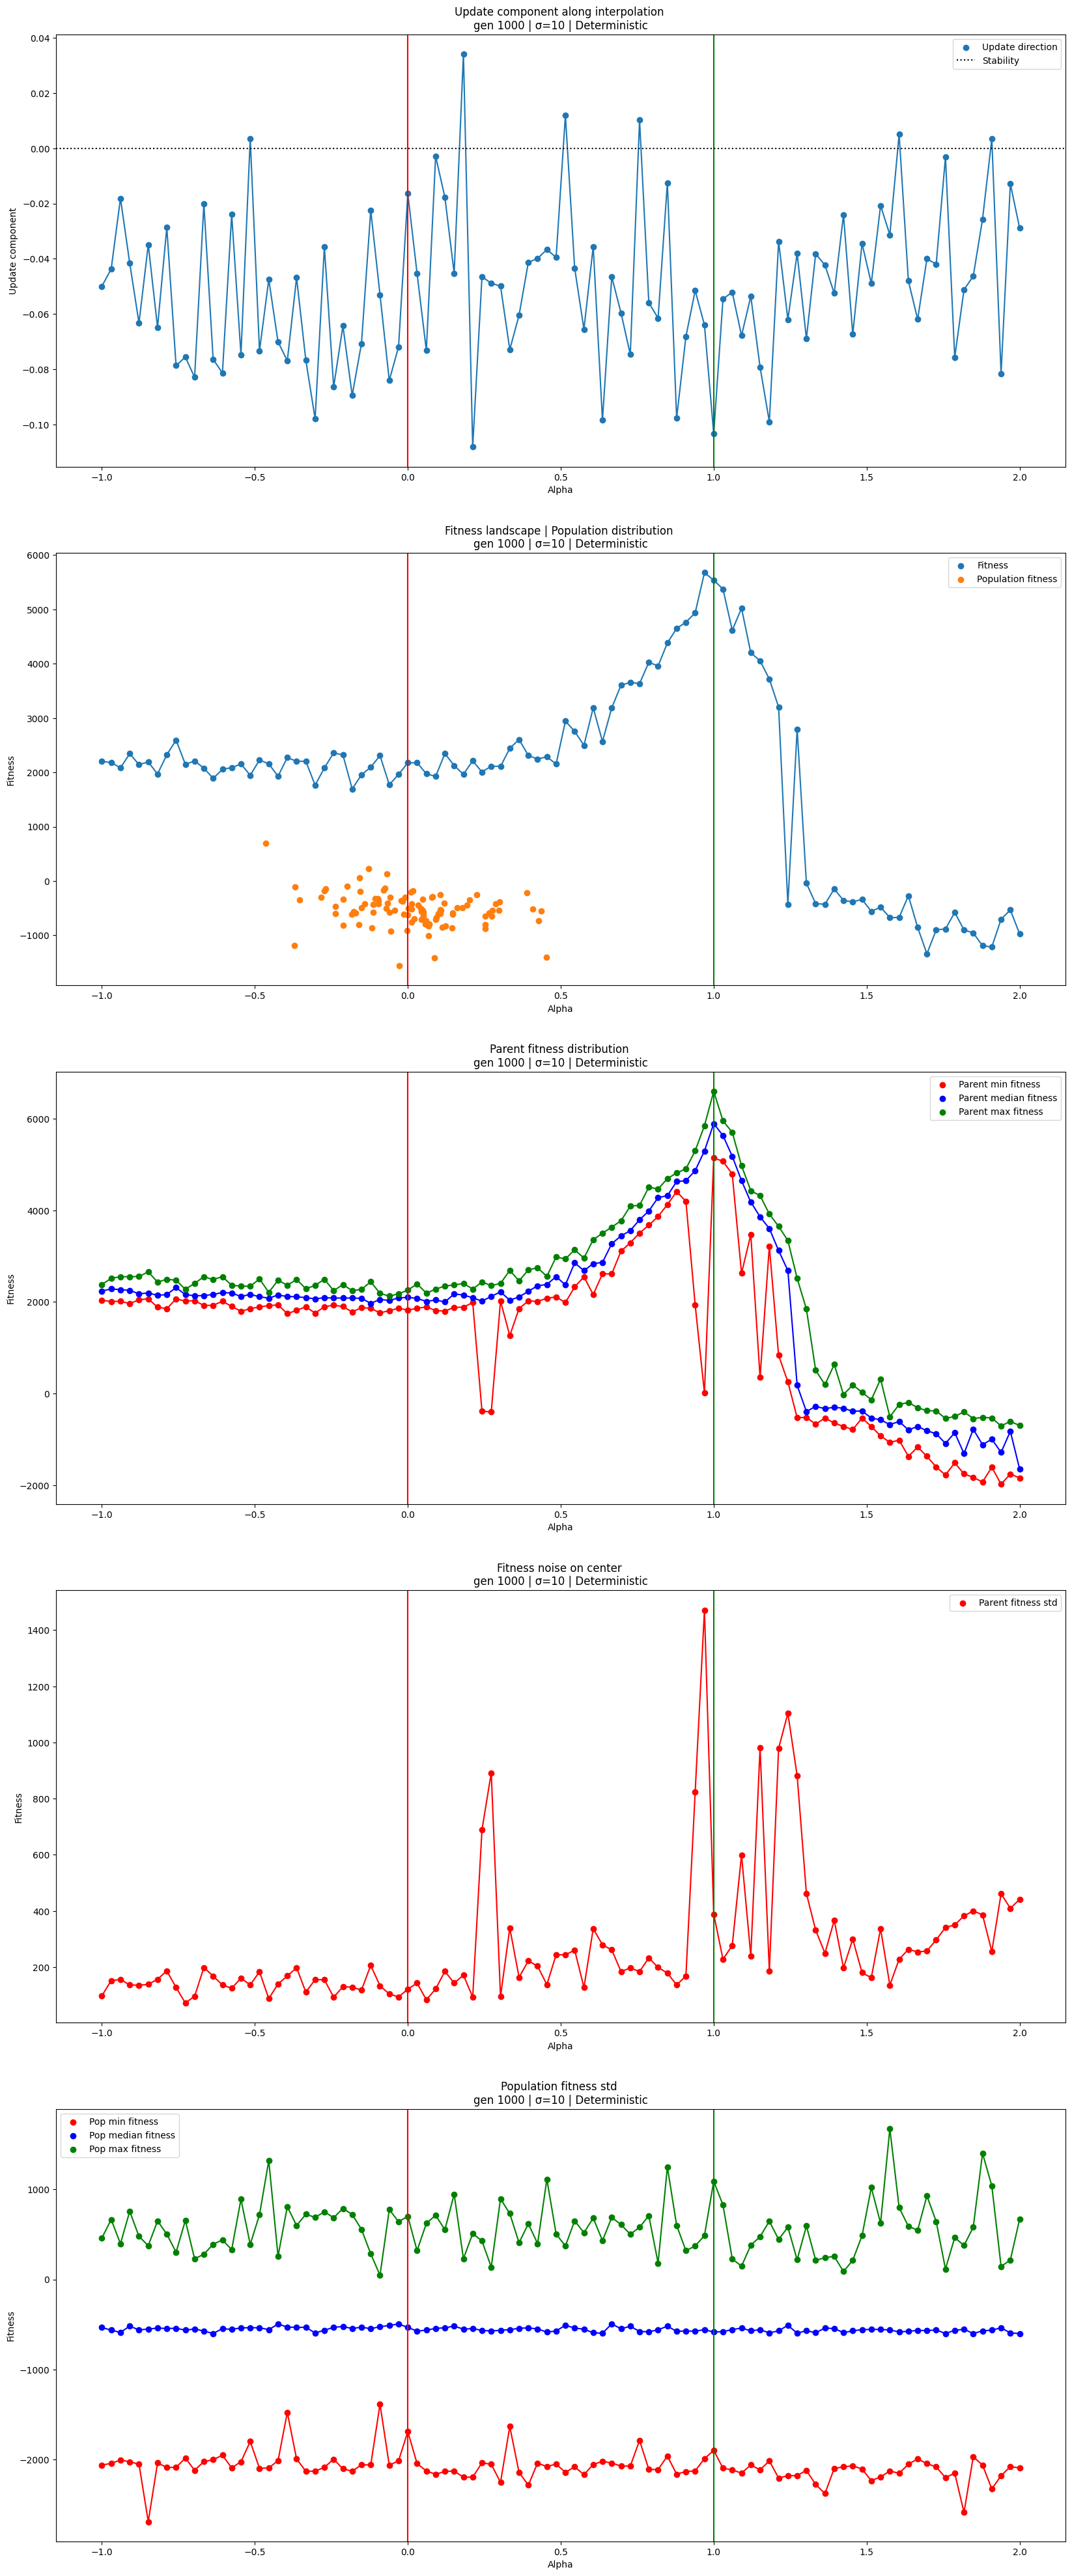

In [48]:
injection = False

# for injection in [True, False]:
stability_plot(save_path, gen, sigma, injection)

In [95]:
for sigma in [1, 0.1, 10]:
    for injection in [True, False]:
        stability_plot(save_path, gen, sigma, injection)

Running gen 1000 | σ=1 | Injection


  0%|          | 0/10 [00:08<?, ?it/s]


KeyboardInterrupt: 

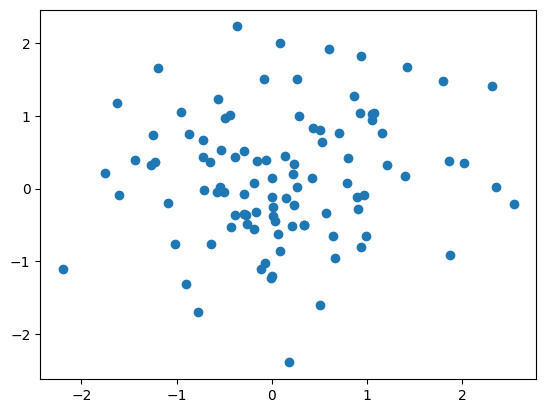

In [4]:
# center = (0, 0) as jnp array
import jax.numpy as jnp
import matplotlib.pyplot as plt
import jax 

n_dim = 2
n_points = 100
center = jnp.zeros(n_dim)

# sample points as gaussian noise
random_key = jax.random.PRNGKey(42)
genomes = jax.random.normal(
    key=random_key,
    shape=(n_points, n_dim),
)

# Scatter
plt.scatter(genomes[:, 0], genomes[:, 1])

v1 = jnp.array([2, 0])